## Atividade Avaliativa 1.2 - _Churn Prediction_

- Redes Neurais Artificiais 2025.2
- Profa. Elloá B. Guedes (ebgcosta@uea.edu.br)
- http://github.com/elloa

### Equipe

- Juliana Ballin Lima (http://github.com/JulianaBallin)
- Marcelo Heitor De Almeida Lira (github.com/integrante2)
- Ryan Da Silva Marinho (github.com/integrante3)

### Apresentação

A previsão de evasão de clientes (_Churn Prediction_) é um problema tipicamente abordado pela Ciência de Dados com o uso de modelos de _Machine Learning_ para identificar clientes com alta probabilidade de descontinuar o uso de um serviço ou produto. Possui extrema importância para o domínio de negócios, especialmente para empresas com modelos de receita baseados em assinatura (SaaS, telecomunicações, serviços de streaming) ou que dependem da fidelidade do cliente, especialmente por:

1. **Impacto na Receita e Lucratividade.** O custo de adquirir um novo cliente é, em geral, significativamente maior do que o custo de reter um cliente existente. A evasão de clientes (churn) representa uma perda direta de receita recorrente. Ao prever quais clientes estão em risco, as empresas podem intervir com estratégias de retenção direcionadas, como ofertas especiais ou suporte aprimorado, minimizando essa perda financeira. A retenção de clientes não só protege a receita atual, mas também contribui para o aumento do _Lifetime Value_ do cliente, que é a receita total que um cliente gera ao longo de sua relação com a empresa;
2. **Otimização de Recursos e Estratégias.** Sem um modelo de previsão, as empresas tendem a adotar estratégias de retenção de forma genérica, aplicando os mesmos esforços a todos os clientes, independentemente do risco de evasão. Isso leva a um desperdício de recursos;
3. **Entendimento do Comportamento do Cliente.** A construção de um modelo de previsão de churn exige a análise aprofundada dos dados de comportamento do cliente. Esse processo revela insights valiosos sobre o que leva os clientes a ficarem ou a saírem, o que não apenas ajuda a reter clientes, mas também auxilia o desenvolvimento de produtos, a melhoria do serviço e a criação de estratégias de marketing mais eficazes para atrair clientes com um perfil de maior lealdade.

### Contexto do Problema

O termo _Telco_ se refere a _telecommunications industry_. Este domínio é particularmente relevante para a análise de churn devido ao seu alto nível de competição e saturação. Os clientes neste setor — seja para serviços de telefonia móvel, internet ou TV a cabo — têm uma vasta gama de provedores à sua escolha, o que torna relativamente fácil para eles migrarem caso estejam insatisfeitos ou encontrem uma oferta melhor.

### Base de Dados

Base de dados original: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

### Bibliotecas

Por hábito, a primeira célula do notebook costuma ser reservada para importação de bibliotecas.
A cada biblioteca nova acrescida, é necessário executar a célula para atualização e correta execução.

In [1]:
#pip install --upgrade pip
#pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Parte 1 - Análise e Exploração de Dados

### Abertura do Dataset
Abra o dataset e visualize o seu cabeçalho, isto é, os primeiros exemplos nele contidos. Isto é útil para checar se a importação foi realizada de maneira adequada e se a disposição dos dados está de acordo para os próximos passos do trabalho.

In [5]:
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "blastchar/telco-customer-churn",
    "WA_Fn-UseC_-Telco-Customer-Churn.csv"
)
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

### Conhecendo o dataset

Para praticar conceitos relativos à exploração do conjunto de dados, utilize as células a seguir para prover respostas para cada uma das respostas elencadas

In [8]:
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


#### Quantos exemplos há no dataset?

In [11]:
print("Number of examples:", len(df))
print("Shape do dataset:", df.shape)

Number of examples: 7043
Shape do dataset: (7043, 21)


#### Dados Faltantes

- Elimine todas as entradas em que há dados faltantes
- Qual o decréscimo percentual no tamanho do dataset?

In [14]:
# Change values in the TotalCharges column to 0 instead of null
# Previously as an object because when creating a new customer, it initializes empty by default
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Delete all rows with missing values
df_clean = df.dropna()

In [16]:
# Dataset len before clean
lines_before = len(df)

# Dataset len after clean
lines_after = len(df_clean)

# Calculate percentage decrease
decr_percent = ((lines_before - lines_after) / lines_before) * 100

print(f"Lines before: {lines_before}")
print(f"Lines after: {lines_after}")
print(f"Percentage decrease: {decr_percent:.2f}%")

Lines before: 7043
Lines after: 7032
Percentage decrease: 0.16%


#### Dados Duplicados

- Verifique se há clientes duplicados (mesmo id é repetido)
- Em caso afirmativo, elimine as duplicatas, favorecendo as entradas mais recentes

In [19]:
# Step 1: Check for duplicate customers (same customerID repeated)
duplicates = df_clean[df_clean.duplicated(subset="customerID", keep=False)]

print("Number of duplicated customerIDs:", duplicates["customerID"].nunique())
print("Total duplicated rows:", len(duplicates))

Number of duplicated customerIDs: 0
Total duplicated rows: 0


In [21]:
#Step 2: If duplicates exist, keep the most recent entry
# We assume 'tenure' (number of months as a customer) represents recency,
# so the higher the tenure, the more recent/complete the record.

# Sort by customerID and tenure in descending order
df_clean = df_clean.sort_values(by=["customerID", "tenure"], ascending=[True, False])

# Drop duplicates, keeping only the most recent record for each customerID
df_clean = df_clean.drop_duplicates(subset="customerID", keep="first")

print("Shape after removing duplicates:", df_clean.shape)

Shape after removing duplicates: (7032, 21)


In [23]:
#Step 3: Verify that all duplicates were removed
remaining_duplicates = df_clean.duplicated(subset="customerID").sum()
print("Remaining duplicates:", remaining_duplicates)

Remaining duplicates: 0


#### Quais os atributos existentes no dataset e seu tipo?

- Exemplos de tipos de dados são categóricos (nominal ou ordinal), numéricos (discreto ou contínuo), textual ou estampa de tempo. Faça uma análise e agrupe por categoria na sua resposta. Observe que analisar os tipos das variáveis não é suficiente.

In [26]:
print(df_clean.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [28]:
#Step 1: Define semantic types for each attribute
semantic_types = {
    # Customer info
    "customerID": "Textual (identifier)",
    
    # Demographics
    "gender": "Categorical (nominal)",
    "SeniorCitizen": "Categorical (binary)",
    "Partner": "Categorical (binary)",
    "Dependents": "Categorical (binary)",
    
    # Service subscription attributes
    "tenure": "Numerical (discrete, ordinal)",
    "PhoneService": "Categorical (binary)",
    "MultipleLines": "Categorical (nominal)",
    "InternetService": "Categorical (nominal)",
    "OnlineSecurity": "Categorical (nominal)",
    "OnlineBackup": "Categorical (nominal)",
    "DeviceProtection": "Categorical (nominal)",
    "TechSupport": "Categorical (nominal)",
    "StreamingTV": "Categorical (nominal)",
    "StreamingMovies": "Categorical (nominal)",
    "Contract": "Categorical (ordinal)",
    "PaperlessBilling": "Categorical (binary)",
    "PaymentMethod": "Categorical (nominal)",
    
    # Charges
    "MonthlyCharges": "Numerical (continuous)",
    "TotalCharges": "Numerical (continuous)",
    
    # Target variable
    "Churn": "Categorical (binary)"
}

In [30]:
# Step 2: Convert dictionary into a DataFrame
semantic_df = pd.DataFrame(
    list(semantic_types.items()),
    columns=["Attribute", "Semantic Type"]
)

# Step 3: Display nicely
print("Attributes and their semantic types:\n")
display(semantic_df)

Attributes and their semantic types:



,Attribute,Semantic Type
0,customerID,Textual (identifier)
1,gender,Categorical (nominal)
2,SeniorCitizen,Categorical (binary)
3,Partner,Categorical (binary)
4,Dependents,Categorical (binary)
5,tenure,"Numerical (discrete, ordinal)"
6,PhoneService,Categorical (binary)
7,MultipleLines,Categorical (nominal)
8,InternetService,Categorical (nominal)
9,OnlineSecurity,Categorical (nominal)


#### Qual cliente paga o maior valor de assinatura mensal e que não faz streaming de filmes?

- Apresente o valor pago mensalmente e os demais atributos desse cliente

In [33]:
# Step 1: Filter customers with no streaming movies
no_movies = df_clean[df_clean["StreamingMovies"] == "No"]

#  Step 2: Get the row with the highest monthly charge among them
highest_no_movies = no_movies.loc[no_movies["MonthlyCharges"].idxmax()]

In [35]:
# Step 3: Display result
print("Customer paying the highest monthly charge without StreamingMovies:")
print("MonthlyCharges:", highest_no_movies["MonthlyCharges"])
display(highest_no_movies.to_frame().T)

Customer paying the highest monthly charge without StreamingMovies:
MonthlyCharges: 106.75


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5544,9572-MTILT,Male,0,Yes,No,59,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,106.75,6252.9,Yes


#### Histograma do tempo de permanência

O histograma é um gráfico que mostra as frequências de uma determinada informação. No nosso caso, vamos construir histogramas que mostram o tempo de permanência no serviço (tenure). Vamos agrupar os valores em bins, cujo número deve ser definido pela Regra de Sturges. 

- Plote dois histogramas, um para os clientes que evadiram do serviço e outro para os que continuaram sua assinatura
- Rotule os eixos e utilize boas práticas de visualização da informação
- Faça a seguinte análise: as distribuições são diferentes?

Documentação completa disponível em: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html


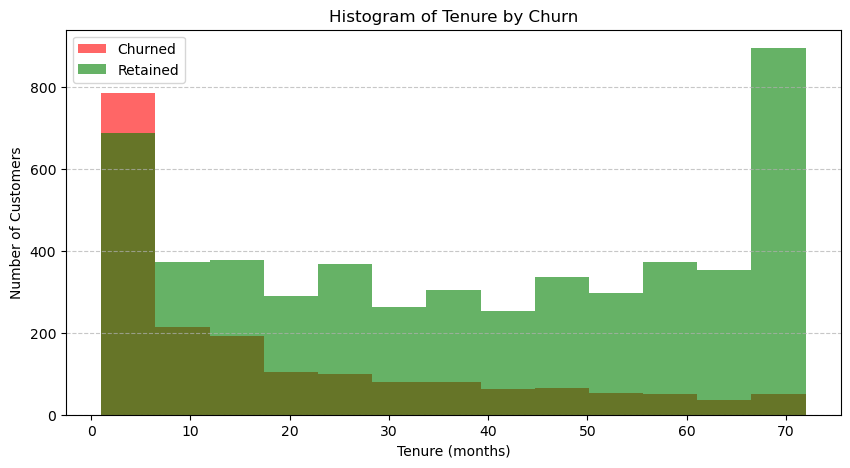

👉 Analysis: The distributions are different.
- Churned customers are concentrated in the first months (low tenure).
- Retained customers are spread across all tenures, with peaks at long-term customers (60–72 months).


In [38]:
# Number of bins using Sturges' rule
n = len(df_clean)
bins = int(1 + np.log2(n))

# Split churned vs retained
tenure_churned = df_clean[df_clean["Churn"] == "Yes"]["tenure"]
tenure_retained = df_clean[df_clean["Churn"] == "No"]["tenure"]

# Plot
plt.figure(figsize=(10,5))
plt.hist(tenure_churned, bins=bins, alpha=0.6, color="red", label="Churned")
plt.hist(tenure_retained, bins=bins, alpha=0.6, color="green", label="Retained")

plt.title("Histogram of Tenure by Churn")
plt.xlabel("Tenure (months)")
plt.ylabel("Number of Customers")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

# Analysis
print("👉 Analysis: The distributions are different.")
print("- Churned customers are concentrated in the first months (low tenure).")
print("- Retained customers are spread across all tenures, with peaks at long-term customers (60–72 months).")

#### Boxplot das Cobranças Mensais

Como é a distribuição das cobranças mensais? O gráfico boxplot pode nos ajudar nesta questão.

O boxplot ilustra informações importantes:
- Mediana
- Limite inferior (menor valor)
- Limite superior (maior valor)
- Q1 (primeiro quartil, 25% dos dados)
- Q3 (terceiro quartil, 75% dos dados)
- Outliers (se houver)

A distribuição dos exemplos no dataset é simétrica no tocante ao atributo em questão? Elabore um parágrafo que justifique as conclusões obtidas a partir da análise do boxplot.

Documentação completa disponível em: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

👉 Analysis: the distribution is asymetric
- The median is slightly closer to the upper quartile and lies above the mean, showing a small asymmetry
- The interquartile range above the median is smaller than the one below it
Conclusion:  the plot shows that higher paying customers are more concentrated in a smaller interval of charge values


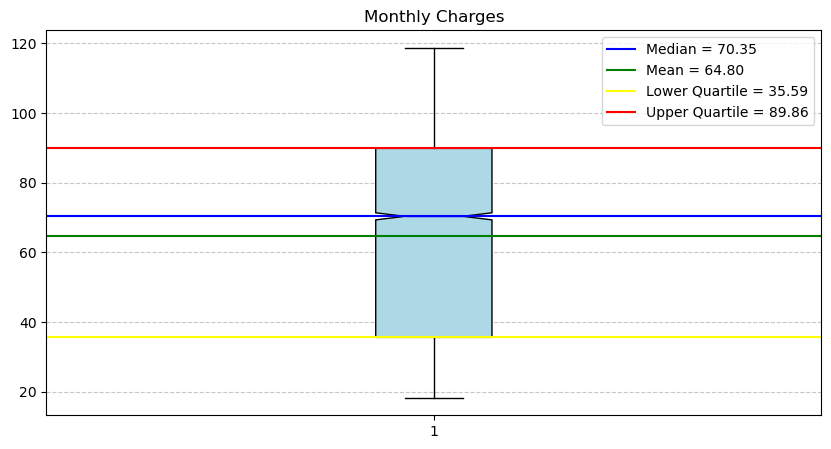

In [134]:
# Entry vector: Monthly Charges
monthly_charges = df_clean["MonthlyCharges"].copy()

# Statistics to be displayed
Q1 = np.percentile(monthly_charges, 25)
Q3 = np.percentile(monthly_charges, 75)
median = np.median(monthly_charges)
mean = np.mean(monthly_charges)

# plot
plt.figure(figsize=(10,5))
plt.boxplot(monthly_charges, notch=True, patch_artist=True, 
            boxprops=dict(facecolor="lightblue"),
            medianprops=dict(color="blue"))
plt.axhline(median, color="blue", linestyle="-", label=f"Median = {median:.2f}")
plt.axhline(mean, color="green", linestyle="-", label=f"Mean = {mean:.2f}")
plt.axhline(Q1, color="yellow", linestyle="-", label=f"Lower Quartile = {Q1:.2f}")
plt.axhline(Q3, color="red", linestyle="-", label=f"Upper Quartile = {Q3:.2f}")

plt.title("Monthly Charges")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.plot()

# Analysis
print("👉 Analysis: the distribution is asymetric")
print("- The median is slightly closer to the upper quartile and lies above the mean, showing a small asymmetry")
print("- The interquartile range above the median is smaller than the one below it")
print("Conclusion:  the plot shows that higher paying customers are more concentrated in a smaller interval of charge values")

#### Taxa de Churn

- Qual a taxa de churn para cada perfil de tipo de pagamento mensal? Há diferenças?

In [132]:
# Payment method and target atribute
churn_by_pay_method = df_clean[["PaymentMethod", "Churn"]].copy()

# Count every churn ocurrence
positive_churn_by_pay_method = churn_by_pay_method[churn_by_pay_method["Churn"] == "Yes"]
churn_total = positive_churn_by_pay_method["Churn"].count()

# Group every payment method
churn_by_pay_method_group = churn_by_pay_method.groupby("PaymentMethod")["Churn"]

#print("Total: ", churn_total)

results = []

for pay_method, df_pay_method in churn_by_pay_method_group:
    # Total customers in this payment method
    total_customers = df_pay_method.shape[0]
    
    # Churn occurence in speific payment method
    positive_churn = df_pay_method[df_pay_method == "Yes"]
    positive_churn_count = df_pay_method[df_pay_method == "Yes"].count()
    
    # Churn rates
    churn_rate_total = (positive_churn.count()/churn_total)*100
    churn_rate_by_method = (positive_churn.count()/df_pay_method.count())*100

    # Appending results to build a DataFrame
    results.append({
        "PaymentMethod": pay_method,
        "TotalCustomers": total_customers,
        "ChurnYes": positive_churn_count,
        "ChurnRateTotal(%)": churn_rate_total,
        "ChurnRateInMethod(%)": churn_rate_by_method
    })


churn_rate = pd.DataFrame(results)

churn_rate

,PaymentMethod,TotalCustomers,ChurnYes,ChurnRateTotal(%),ChurnRateInMethod(%)
0,Bank transfer (automatic),1542,258,13.804173,16.731518
1,Credit card (automatic),1521,232,12.413055,15.253123
2,Electronic check,2365,1071,57.303371,45.285412
3,Mailed check,1604,308,16.479401,19.201995


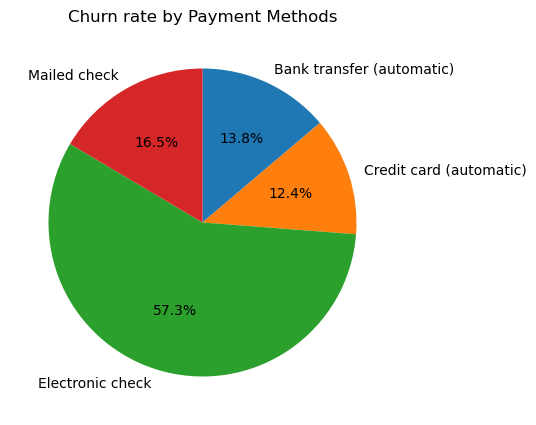

In [46]:
# plot
labels = churn_rate["PaymentMethod"]
sizes = churn_rate["ChurnYes"]

plt.figure(figsize=(5, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)

plt.title("Churn rate by Payment Methods")
plt.show()

In [48]:
print("👉 Customers who pay with Electronic check appear to have a significantly higher likelihood of churning compared to other payment methods.")
print("- The other payment methods have similar churn rates")

👉 Customers who pay with Electronic check appear to have a significantly higher likelihood of churning compared to other payment methods.
- The other payment methods have similar churn rates


#### Avaliação de Hipóteses

Analise as seguintes hipóteses, elaborando gráficos e consulta aos dados para embasar suas justificativas:

- Hipótese 1: "Clientes que optaram por serviços como TechSupport (suporte técnico) têm uma probabilidade menor de churn."
- Hipótese 2: "A taxa de churn é significativamente maior para clientes com contratos de curto prazo em comparação com aqueles com contratos de longo prazo."
- Hipótese 3: "Clientes com múltiplos serviços, com dependentes e que fazem backup online possuem baixa probabilidade de trocar de prestadora"

In [51]:
def churn_rate_tech_support(df):
    df = df["Churn"]
    total = df.count()
    
    # Number of churns and retentions
    churn_total = df[df == "Yes"].count()
    retention_total = df[df == "No"].count()
    
    churn_rate = (churn_total/total)*100
    retention_rate = (retention_total/total)*100
    
    return churn_rate, retention_rate

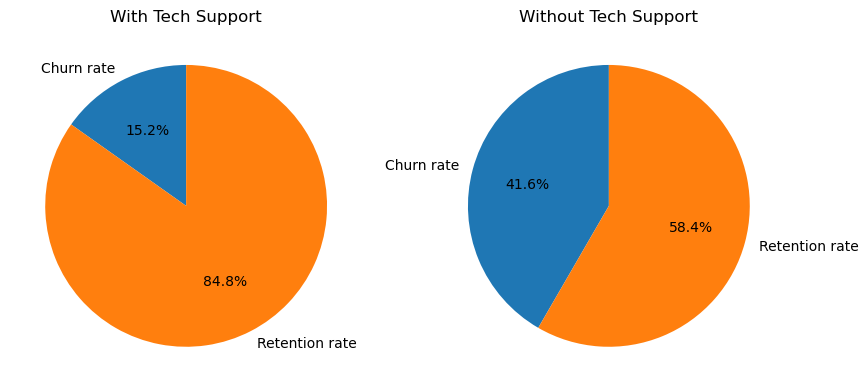

In [130]:
# Hypothesis 1: Customers who opt for services like TechSupport are less likely to churn.

# Tech Support and Churn
tech_support_churn = df_clean[["TechSupport", "Churn"]].copy()

# Divide dataset by use of Tech Support
used_tech_support = tech_support_churn[tech_support_churn["TechSupport"] == "Yes"]
not_used_tech_support = tech_support_churn[tech_support_churn["TechSupport"] == "No"]

# Get churn rates
churn_rate_with_tech, retention_rate_with_tech = churn_rate_tech_support(used_tech_support)
churn_rate_no_tech, retention_rate_no_tech = churn_rate_tech_support(not_used_tech_support)

# plot
plt.figure(figsize=(10, 5))

# Com Tech Support
plt.subplot(1, 2, 1)
plt.pie(
    [churn_rate_with_tech, retention_rate_with_tech],
    labels=["Churn rate", "Retention rate"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("With Tech Support")

# Sem Tech Support
plt.subplot(1, 2, 2)
plt.pie(
    [churn_rate_no_tech, retention_rate_no_tech],
    labels=["Churn rate", "Retention rate"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Without Tech Support")

plt.show()

In [55]:
print("👉 Conclusion: Clients that use Tech Support have a higher retention rate. The first hypothesis is true.")

👉 Conclusion: Clients that use Tech Support have a higher retention rate. The first hypothesis is true.


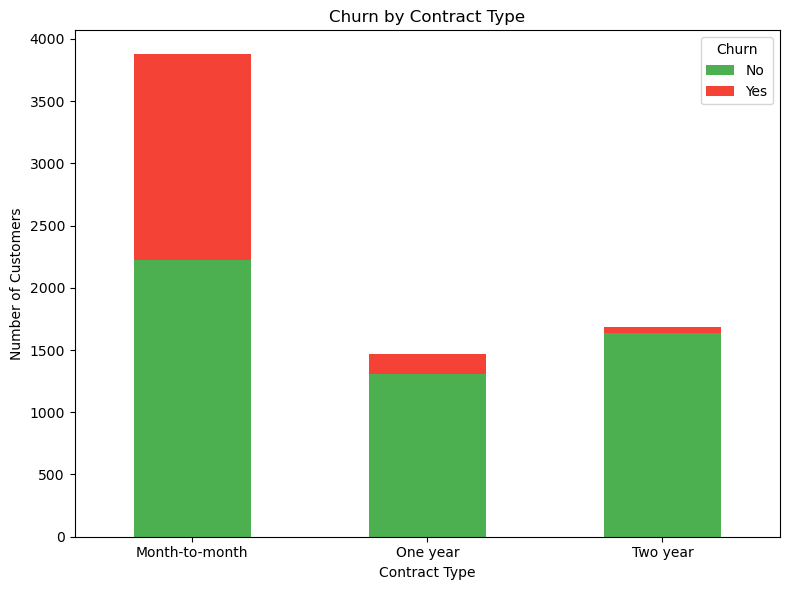

👉 Conclusion: The bar plot clearly shows that churn is significantly higher among customers with month-to-month contracts compared to those with one-year or two-year contracts.
- Therefore, the second hypothesis is supported by the data.


In [128]:
# Hypothesis 2: The churn rate is significantly higher for customers with short-term contracts compared to those with long-term contracts.

# Contracts and Churn
churn_by_contract = df_clean[["Contract", "Churn"]].copy()

# Group by contract types and Churn
churn_counts = churn_by_contract.groupby(["Contract", "Churn"]).size().unstack()

# plot
churn_counts.plot(kind="bar", stacked=True, figsize=(8,6), color=["#4caf50", "#f44336"])
plt.title("Churn by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Number of Customers")
plt.legend(title="Churn", labels=["No", "Yes"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("👉 Conclusion: The bar plot clearly shows that churn is significantly higher among customers with month-to-month contracts compared to those with one-year or two-year contracts.")
print("- Therefore, the second hypothesis is supported by the data.")


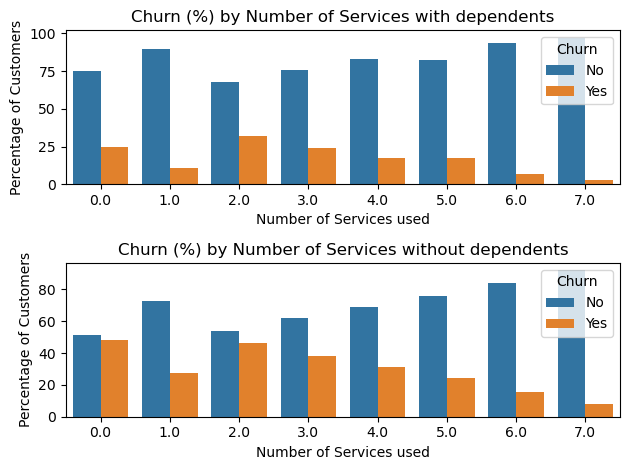

In [166]:
# Hypothesis 3: Customers with multiple services, with dependents and who make online backups have a low probability of changing providers

def churn_rate_by_group(df):
    counts = df.groupby(["NumberServices", "Churn"]).size().reset_index(name="Count")
    counts["Percent"] = counts.groupby("NumberServices")["Count"].transform(lambda x: 100 * x / x.sum())
    return counts

# Columns to be used
columns = ['Dependents', 'PhoneService', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 
           'StreamingTV', 'StreamingMovies', 'Churn']

# DataFrame with services
mult_services = df_clean[columns].copy()

mult_services_dependents = mult_services[mult_services["Dependents"] == "Yes"].copy()
mult_services_no_dependents = mult_services[mult_services["Dependents"] == "No"].copy()

mult_services["NumberServices"] = None
services_count = 0

columns.remove("Churn")
columns.remove("Dependents")

# Create new column with number of services used
for index, row in mult_services_dependents.iterrows():
    for column in columns:
        if row[column] == 'Yes':
            services_count += 1
    mult_services_dependents.at[index, "NumberServices"] = services_count
    services_count = 0

for index, row in mult_services_no_dependents.iterrows():
    for column in columns:
        if row[column] == 'Yes':
            services_count += 1
    mult_services_no_dependents.at[index, "NumberServices"] = services_count
    services_count = 0



mult_services_dependents = churn_rate_by_group(mult_services_dependents)
mult_services_no_dependents = churn_rate_by_group(mult_services_no_dependents)

# plot
plt.subplot(2, 1, 1)
sns.barplot(x="NumberServices", y="Percent", hue="Churn", data=mult_services_dependents)
plt.title("Churn (%) by Number of Services with dependents")
plt.xlabel("Number of Services used")
plt.ylabel("Percentage of Customers")

plt.subplot(2, 1, 2)
sns.barplot(x="NumberServices", y="Percent", hue="Churn", data=mult_services_no_dependents)
plt.title("Churn (%) by Number of Services without dependents")
plt.xlabel("Number of Services used")
plt.ylabel("Percentage of Customers")

plt.tight_layout()
plt.show()



In [170]:
print("👉 Conclusion: Both graphs have similar trends, where the more services are used, more likely the customer is to stay")
print("The third hypothesis is true")

👉 Conclusion: Both graphs have similar trends, where the more services are used, more likely the customer is to stay
The third hypothesis is true


#### Perfil do Cliente de Risco

Crie uma série de 3 a 4 gráficos conectados que, juntos, respondam à seguinte pergunta:

_**Qual é o perfil do cliente com alta probabilidade de churn e o que mais o influencia a sair?**_

1. Visualização da Distribuição de Permanência (Tenure)  
- Gráfico: Histograma ou gráfico de densidade comparando o tempo de permanência (tenure) de clientes que saíram (Churn = Yes) com o de clientes que ficaram (Churn = No).
- Objetivo: Mostrar visualmente se o churn é mais comum entre clientes novos ou antigos.

2. Análise da Relação entre Tipo de Contrato e Evasão
- Gráfico: Gráfico de barras agrupadas ou empilhadas que mostre a taxa de churn para cada tipo de contrato (Monthly, One year, Two year).
- Objetivo: Demonstrar o impacto do tipo de contrato na decisão do cliente de sair.

3. Combinação de Variáveis: Preços e Serviços
- Gráfico: Gráfico de dispersão (scatter plot) ou um gráfico de box plot que combine duas variáveis-chave, como MonthlyCharges (cobranças mensais) e o tipo de serviço de internet (InternetService), segmentado pela variável Churn.
- Objetivo: Revelar se clientes que pagam mais por um tipo específico de serviço (ex: Fibra Óptica) têm uma taxa de churn diferente. Isso pode sugerir, por exemplo, que a insatisfação está ligada à qualidade de um serviço mais caro.


Escreva um breve parágrafo resumindo as descobertas. A resposta deve conectar as visualizações, respondendo à pergunta inicial sobre o perfil do cliente em risco de forma coesa e baseada nas evidências visuais.

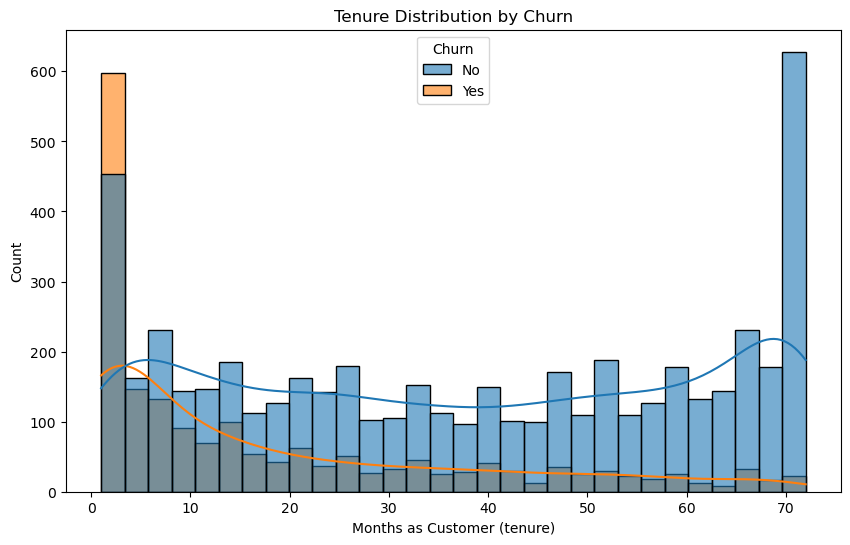

In [53]:
# 1- Tenure distribution by Churn
# Plotting tenure distribution for Churn vs No Churn

plt.figure(figsize=(10,6))
sns.histplot(data=df_clean, x="tenure", hue="Churn", kde=True, bins=30, alpha=0.6)
plt.title("Tenure Distribution by Churn")
plt.xlabel("Months as Customer (tenure)")
plt.ylabel("Count")
plt.show()

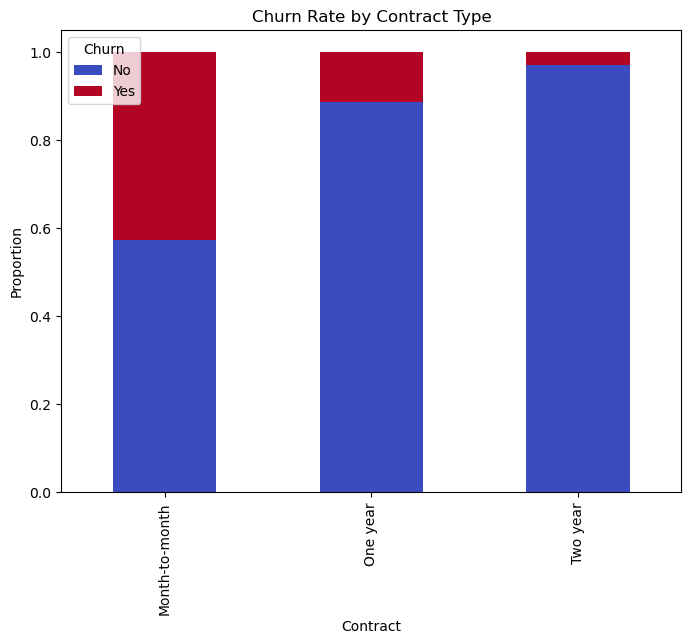

In [54]:
# 2 - Contract type vs Churn
# [Plotting churn rate by contract type

contract_churn = pd.crosstab(df_clean["Contract"], df_clean["Churn"], normalize="index")
contract_churn.plot(kind="bar", stacked=True, figsize=(8,6), colormap="coolwarm")
plt.title("Churn Rate by Contract Type")
plt.ylabel("Proportion")
plt.show()

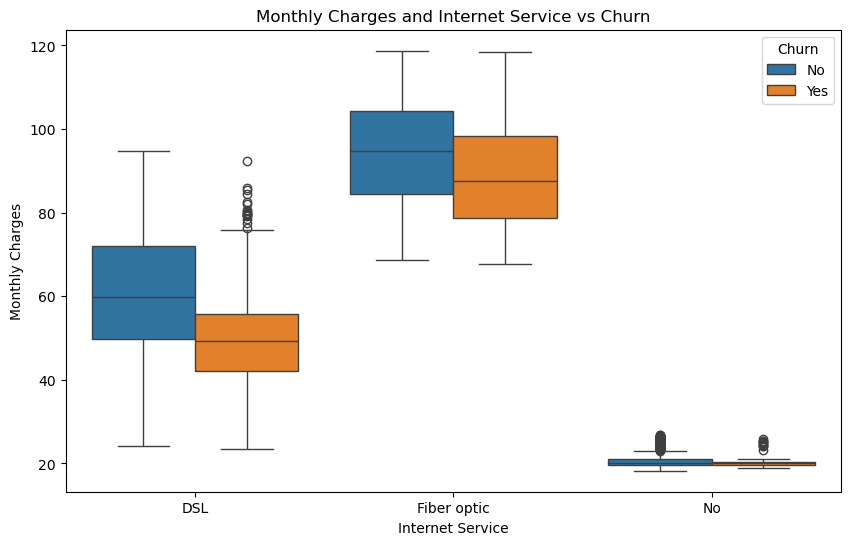

In [55]:
# 3 - Monthly charges and Internet service vs Churn
# Boxplot showing MonthlyCharges by InternetService segmented by Churn
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_clean,
    x="InternetService",
    y="MonthlyCharges",
    hue="Churn"
)
plt.title("Monthly Charges and Internet Service vs Churn")
plt.xlabel("Internet Service")
plt.ylabel("Monthly Charges")
plt.show()


In [56]:
# 4 - Resumo
conclusao_pt = """
Os gráficos mostram que o churn ocorre principalmente entre clientes recentes (tenure baixo),
o que sugere dificuldade de retenção inicial. Além disso, clientes com contratos mensais são
os mais propensos a sair, enquanto contratos anuais e bienais têm taxas de evasão bem menores.
Por fim, observamos que clientes que pagam valores mensais mais altos, especialmente pelo serviço
de Fibra Óptica, apresentam maior probabilidade de churn. Assim, o perfil de risco combina novos
clientes, com contrato mensal, pagando caro pelo serviço de fibra, o que indica insatisfação tanto
pelo preço quanto pela qualidade percebida do serviço.
"""
print(conclusao_pt)


Os gráficos mostram que o churn ocorre principalmente entre clientes recentes (tenure baixo),
o que sugere dificuldade de retenção inicial. Além disso, clientes com contratos mensais são
os mais propensos a sair, enquanto contratos anuais e bienais têm taxas de evasão bem menores.
Por fim, observamos que clientes que pagam valores mensais mais altos, especialmente pelo serviço
de Fibra Óptica, apresentam maior probabilidade de churn. Assim, o perfil de risco combina novos
clientes, com contrato mensal, pagando caro pelo serviço de fibra, o que indica insatisfação tanto
pelo preço quanto pela qualidade percebida do serviço.



In [57]:
# 4 - Resume
conclusion_en = """
The graphs show that churn occurs mainly among recent customers (low tenure),
suggesting difficulties with initial retention. In addition, customers with
monthly contracts are the most likely to leave, while those with one-year and
two-year contracts show much lower churn rates. Finally, we observe that customers
who pay higher monthly charges, especially for Fiber Optic service, have a higher
probability of churn. Thus, the risk profile combines new customers with monthly
contracts, paying higher prices for fiber service, which indicates dissatisfaction
both with cost and with perceived quality of the service.
"""
print(conclusion_en)


The graphs show that churn occurs mainly among recent customers (low tenure),
suggesting difficulties with initial retention. In addition, customers with
monthly contracts are the most likely to leave, while those with one-year and
two-year contracts show much lower churn rates. Finally, we observe that customers
who pay higher monthly charges, especially for Fiber Optic service, have a higher
probability of churn. Thus, the risk profile combines new customers with monthly
contracts, paying higher prices for fiber service, which indicates dissatisfaction
both with cost and with perceived quality of the service.



#### Gênero do Cliente

Conforme a documentação da base de dados, há dois valores possíveis para o gênero do cliente, são eles:  
    - M: Masculino  
    - F: Feminino  
    
Tal como dispostos, segundo strings, essas informações não ajudam modelos que lidam apenas com dados numéricos. É necessário efetuar uma codificação para representar tais valores. Assim, codifique a coluna gender conforme a abordagem One-Hot Encoding e elimine a coluna original do dataset.

Referências:
- https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

#### Codificação dos Atributos

- Se o atributo tiver duas categorias, repita o processo de codificação conforme proposto anteriormente. 
- Senão se o atributo tiver entre três e até cinco categorias, utilize Label Encoding.
- Em caso contrário, elimine a coluna em questão.

Referências:
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


#### O dataset é balanceado?

- Considera-se que o dataset é balanceado se não houver mais de 10% de diferença no quantitativo das classes nele presentes. Faça a avaliação nesses termos. Elabore gráficos que justificam sua resposta.
- A partir da resposta considerada, apresente quatro métricas de desempenho a serem utilizadas na avaliação comparativa de modelos para esse problema

## Parte 2 - Tarefa de Aprendizado de Máquina

Abordaremos o problema da previsão de churn como uma tarefa de classificação binária.

#### Preparação dos dados para Validação Cruzada Holdout

- Vamos separar o atributo alvo (Age) dos atributores preditores. 
  - Atributos preditores devem ser armazenados em uma variável denominada X  
  - Atributo alvo deve ser armazenado em uma variável denominada y
- Qual o tipo de entrada do modelo?
- Vamos efetuar uma partição do tipo holdout estratificada 70/30

Documentação completa disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [84]:
# Preparação dos dados para Validação Cruzada Holdout
from sklearn.model_selection import train_test_split

# Separando o atributo alvo (Churn) dos atributos preditores
X = df_clean.drop(columns=['Churn', 'customerID'])  # Atributos preditores (excluindo 'Churn' e 'customerID')
y = df_clean['Churn']  # Atributo alvo

# Convertendo variáveis categóricas em variáveis dummy (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Convertendo o alvo para valores binários (0 e 1)
y = y.map({'No': 0, 'Yes': 1})

# Efetuando a partição holdout estratificada 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("Formato dos conjuntos de treino e teste:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Formato dos conjuntos de treino e teste:
X_train: (4922, 30), X_test: (2110, 30)
y_train: (4922,), y_test: (2110,)


#### Treinar um modelo de regressão logística para o problema

A Regressão Logística é uma técnica de Aprendizado de Máquina que tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a predição de valores tomados por uma variável categórica, frequentemente binária, a partir de uma série de variáveis explicativas.

1. Importe o modelo da biblioteca sklearn
2. Instancie o modelo com parâmetros padrão (default)
3. Execute o algoritmo de treinamento com os dados de treino

Documentação completa disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [86]:
# Treinar um modelo de regressão logística para o problema

# Instanciando o modelo com parâmetros padrão
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Executando o algoritmo de treinamento com os dados de treino
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### Obtendo previsões do modelo

1. Selecione um exemplo arbitrário da partição de teste
2. Forneça os atributos preditores e obtenha a previsão da churn
3. O modelo previu a saída corretamente?

In [88]:
# Obtendo previsões do modelo
# Selecionando um exemplo arbitrário (por exemplo, o primeiro exemplo do conjunto de teste)
exemplo = X_test.iloc[0:1]
previsao = log_reg.predict(exemplo)
probabilidade = log_reg.predict_proba(exemplo)

print(f"Atributos do exemplo: {exemplo.values}")
print(f"Previsão para o exemplo: {'Churn' if previsao[0] == 1 else 'No Churn'}")
print(f"Probabilidade: {probabilidade[0]}")
print(f"Valor real: {'Churn' if y_test.iloc[0] == 1 else 'No Churn'}")

Atributos do exemplo: [[0 39 59.8 2343.85 True True True True False False False False False
  True False True False True False False False False False False True
  False False False True False]]
Previsão para o exemplo: No Churn
Probabilidade: [0.95408104 0.04591896]
Valor real: No Churn


#### Avalie o modelo perante o conjunto de testes

1. Obtenha as métricas elencadas para o conjunto de testes
  * Efetue a importação de tais métricas a partir do pacote sklearn.metrics
2. Elabore uma visualização da matriz de confusão normalizada para as previsões do conjunto de testes
3. O modelo é bom para o problema? Justifique sua afirmação.

Acurácia: 0.8024
Precisão: 0.6558
Recall: 0.5401
F1-Score: 0.5924


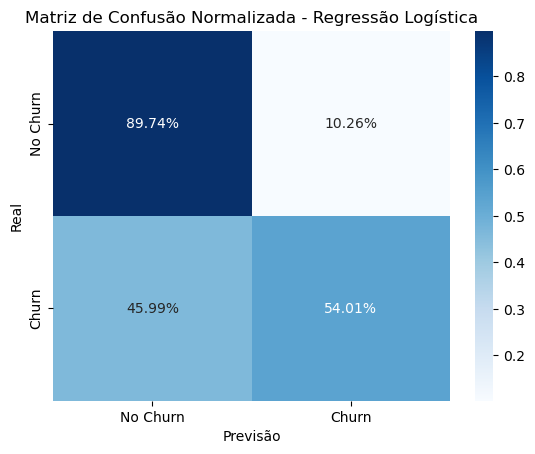

In [89]:
# Avalie o modelo perante o conjunto de testes

# Obtendo previsões para o conjunto de teste
y_pred_log_reg = log_reg.predict(X_test)

# Calculando métricas
accuracy = accuracy_score(y_test, y_pred_log_reg)
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusão normalizada
cm = confusion_matrix(y_test, y_pred_log_reg, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão Normalizada - Regressão Logística')
plt.show()

#### Treinar um modelo de K-Vizinhos Mais Próximos

É um algoritmo de Aprendizado de Máquina que baseia-se na média dos valores dos k vizinhos mais próximos a uma dada entrada para produzir uma estimativa para o atributo-alvo. É considerado "preguiçoso", mas muito mostra-se vantajoso por possuir um baixo custo computacional.

1. Efetue o treinamento do K-Vizinhos mais Próximos, considerando k = 5
2. Efetue o teste no modelo e obtenha as métricas de desempenho previamente indicadas.  

#### Treinar um modelo de Árvore de Decisão

É um modelo de aprendizado de máquina supervisionado, utilizado para problemas de classificação e regressão. Sua estrutura se assemelha a um fluxograma, em que cada nó interno representa um teste em uma atributo dado, cada ramo corresponde a um resultado desse teste, e cada nó folha a uma decisão final ou previsão. Destaca-se por sua interpretabilidade

1. Efetue o treinamento do Árvore de Decisão, utilizando o critério de entropia.
2. Efetue o teste no modelo e obtenha as métricas de desempenho previamente indicadas.  
3. Plote a árvore de decisão construída.

#### Síntese dos Resultados

- Agrupe as matrizes de confusão obtidas lado a lado
- Crie uma tabela com todos os modelos e métricas (Pretty Table)

#### Argumente

- Qual o melhor modelo para o problema em questão?
- Qual o grau de dificuldade da tarefa de aprendizado proposta? Justifique a partir dos elementos e resultados obtidos nas células anteriores.